# Lab 1: image rectification

This lab has two main goals:

1) Get more familiar with the hierarchy of 2D transformation <br>

2) Remove the projective distortion of an image of a planar object (image rectification)

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [17]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil
from utils import line_draw, plot_img
from scipy import linalg as SCIPY_LA

import sys

In [18]:
# utils functions
def array_to_image(I_array):
    return Image.fromarray(I_array.astype(np.uint8))

def get_points(A, idx):
    p1 = [A[idx, 0], A[idx, 1], 1] # initial point in line i
    p2 = [A[idx, 2], A[idx, 3], 1] # final point in line i
    return p1,p2

def draw_image_lines(I, lines):
    # show the chosen lines in the image
    canv = ImageDraw.Draw(I)
    point_color = (0, 0, 255)

    for l in lines:
        line_draw(l, canv, I.size)

    # The displayed lines will alter image I so we have to reopen the original image after the plot
    plot_img(I)

## **1. Applying image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to animage.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so as to 
contain the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [19]:
def apply_H(I, H):
    
    # for the size of the image
    h, w, n_channels = I.shape
  
    tl_h = np.matmul(H,np.transpose([0,0,1]))
    tr_h = np.matmul(H,np.transpose([w,0,1]))
    bl_h = np.matmul(H,np.transpose([0,h,1]))
    br_h = np.matmul(H,np.transpose([w,h,1]))
    
    coords_h = np.asarray([tl_h, tr_h, br_h, bl_h])
    coords_c = np.empty(shape=(4, 2))
    coords_c[:, 0] = np.divide(coords_h[:, 0], coords_h[:, 2])
    coords_c[:, 1] = np.divide(coords_h[:, 1], coords_h[:, 2])
                
    x_max = int(np.max(coords_c[:,0]))
    x_min = int(np.min(coords_c[:,0]))
    y_max = int(np.max(coords_c[:,1]))
    y_min = int(np.min(coords_c[:,1]))
        
    w_out = x_max-x_min+1
    h_out = y_max-y_min+1

    out_cols = np.arange(x_min, x_max+1, 1)
    out_rows = np.arange(y_min, y_max+1, 1)
    out_coords = np.empty((w_out, h_out, 3))
    out_coords[..., 0] = out_cols[:, None]
    out_coords[..., 1] = out_rows
    out_coords[..., 2] = 1
        
    H_inv = LA.inv(H)
    
    original_coords = out_coords.copy()
    
    for idx_col, col in enumerate(original_coords):
        for idx_row, row in enumerate(col):
            original_coords[idx_col, idx_row] = np.matmul(H_inv,np.transpose(row))
    
    original_coords = original_coords.reshape(h_out*w_out,3)
    original_coords_c = np.empty(shape=(h_out*w_out, 2))
    original_coords_c[:, 0] = np.divide(original_coords[:, 0], original_coords[:, 2])
    original_coords_c[:, 1] = np.divide(original_coords[:, 1], original_coords[:, 2])
    
    original_coords_c = original_coords_c.reshape(w_out,h_out,2)
    
    x_coords = original_coords_c[:,:,0].reshape(w_out,h_out)
    y_coords = original_coords_c[:,:,1].reshape(w_out,h_out)

    out = np.zeros((w_out, h_out, n_channels))
    for i in range(n_channels):
        out[:, :, i] = map_coordinates(I[:,:,i],[y_coords, x_coords], mode='constant')
    
    return np.transpose(out, (1,0,2)), [x_min, x_max, y_min, y_max]

### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a similarity transformation. </span>

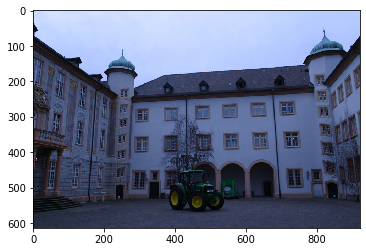

In [20]:
# Format of H in the slides (Lecture 2a)
def _create_H(R, s, t):
    return [[s*R[0][0],  s*R[0][1],  t[0]], 
             [s*R[1][0],  s*R[1][1],  t[1]], 
             [0,  0,  1]]
img_path = "./Data/0000_s.png"
I = Image.open(img_path)
plot_img(I)

# Only Scale
theta = 0 # Random angle
R = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]] #Rotation matrix (https://en.wikipedia.org/wiki/Rotation_matrix)
s = 0.5 # Scaling factor
t = [0, 0] # Translation Vector (random values)
I_scale, axis_scale = apply_H(np.array(I), _create_H(R, s, t))

# Scale and rotation
s = 0.5
theta = 0.1*np.pi
R = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]] #Rotation matrix (https://en.wikipedia.org/wiki/Rotation_matrix)
I_scale_rotation, axis_scale_rotation = apply_H(np.array(I), _create_H(R, s, t))

# Scale, rotation and translation
t = [400, 300]
I_scale_translation_rotation, axis_scale_translation_rotation = apply_H(np.array(I), _create_H(R, s, t))

### Scale only

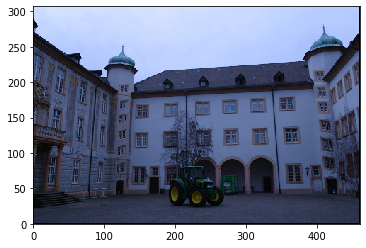

In [21]:
plot_img(array_to_image(I_scale), axis=axis_scale)

### Scale and Rotation

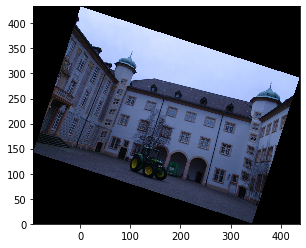

In [22]:
plot_img(array_to_image(I_scale_rotation), axis=axis_scale_rotation)

### Scale, translation and Rotation

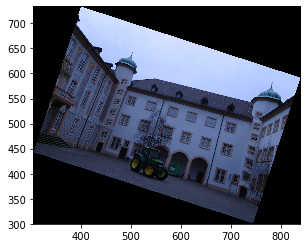

In [23]:
plot_img(array_to_image(I_scale_translation_rotation), axis=axis_scale_translation_rotation)

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces an affine transformation.  </span>


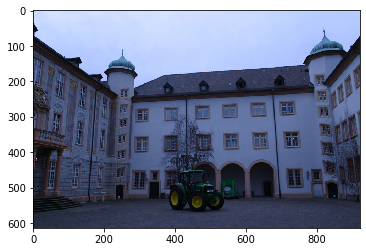

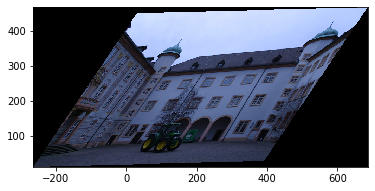

In [120]:
# Format of H in the slides (Lecture 2a)
theta=0.1*np.pi;
fi=0.3*np.pi;
s=[1, 0.5];
t=[30, 30];

R1 = [[np.cos(theta), -np.sin(theta), 0],
      [np.sin(theta),  np.cos(theta), 0],
      [0          ,  0          , 1]]
  
R2a = [[np.cos(fi), -np.sin(fi), 0],
       [np.sin(fi),  np.cos(fi), 0],
       [0       ,  0       , 1]]
  
R2b = [[np.cos(-fi), -np.sin(-fi), 0],
       [np.sin(-fi),  np.cos(-fi), 0],
       [0        ,  0        , 1]]
  
S = [[s[0], 0   , 0],
     [0   , s[1], 0],
     [0   , 0   , 1]]

T = [[0, 0, t[0]],
     [0, 0, t[1]],
     [0, 0,  0]]

Haff = np.matmul(R1,np.matmul(R2b,np.matmul(S,R2a))) + T
   
img_path = "./Data/0000_s.png"
I = Image.open(img_path)
I_aff,aff_axis = apply_H(np.array(I), Haff)

plot_img(I)
plot_img(array_to_image(I_aff), axis=aff_axis)


<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>


In [121]:
# SVD decomposition: R1*(transpose(R2)*D*R2) = U*transpose(V)*(V*D*transpose(V))
U,D,V = LA.svd(Haff[:2,:2])

print("U: {}, D: {}, V: {}".format(U,D,V))
R1d = np.matmul(U,V)
R2d = V
Sd = np.diag(D)
Td = np.array([t[0],t[1]])
print("R1d: {}, R2d: {}, Sd: {}, Td: {}".format(R1d,R2d,Sd,Td))

U: [[-0.80901699  0.58778525]
 [ 0.58778525  0.80901699]], D: [1.  0.5], V: [[-0.58778525  0.80901699]
 [ 0.80901699  0.58778525]]
R1d: [[ 0.95105652 -0.30901699]
 [ 0.30901699  0.95105652]], R2d: [[-0.58778525  0.80901699]
 [ 0.80901699  0.58778525]], Sd: [[1.  0. ]
 [0.  0.5]], Td: [30 30]


<span style='color:Green'> - verify that the product of the four previous transformations produces the same matrix H as above.   </span>

In [122]:
#Haff2 = HR1 @ (np.transpose(HR2) @ HScale @ HR2)
#A = np.matmul(R1d, np.matmul(np.transpose(R2d),np.matmul(Sd,R2d)))
A = R1d @ (V @ Sd @ R2d)


Haff2 = np.zeros((3,3))
Haff2[2,2] = 1

Haff2[0:2,2] = Td

Haff2[0:2,0:2] =  A

print(Haff)
print(Haff2)

mse = ((Haff - Haff2)**2).mean(axis=None)
print("MSE = {}".format(mse))

[[ 7.13292387e-01 -4.81762746e-01  3.00000000e+01]
 [-1.82372542e-02  7.13292387e-01  3.00000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 7.13292387e-01 -4.81762746e-01  3.00000000e+01]
 [-1.82372542e-02  7.13292387e-01  3.00000000e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
MSE = 3.055808845094414e-32


<span style='color:Green'> - verify that the proper sequence of the four previous
transformations over the image I produces the same transformed image as before.  </span>

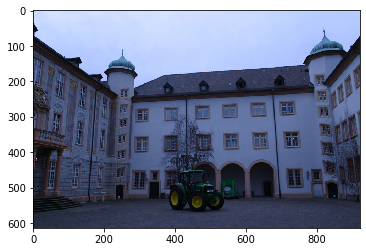

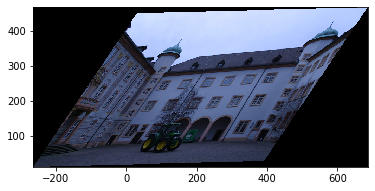

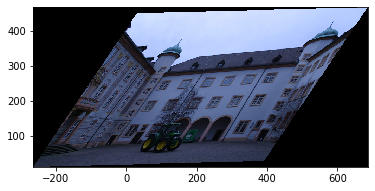

In [123]:
I_aff2, aff2_axis = apply_H(np.array(I), Haff2)

plot_img(I)
plot_img(array_to_image(I_aff), axis=aff_axis)
plot_img(array_to_image(I_aff2), axis=aff2_axis)

### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a projective transformation.  </span>

C:\Users\Ian\anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Ian\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


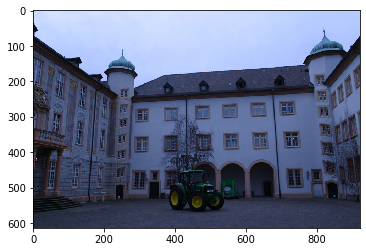

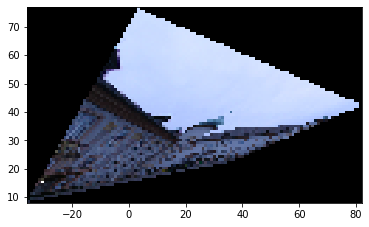

In [108]:
# Format of H in the slides (Lecture 2a)

A = [[0.5, -0.25],[0.25, 0.5]] # random non-singular 2x2 matrix
t = [3, 8] # Translation Vector (random values)
v = [0.005, 0.005] 
vv = 1

Hp = [[A[0][0],  A[0][1],  t[0]], 
     [A[1][0],  A[1][1],  t[1]], 
     [v[0],  v[1],  vv]]

img_path = "./Data/0000_s.png"
I = Image.open(img_path)

I_proj, proj_axis = apply_H(np.array(I), Hp)

     
plot_img(I)
plot_img(array_to_image(I_proj), axis = proj_axis)

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

In [47]:
# load images and lines
img_path = "./Data/0000_s.png"
I = Image.open(img_path)

lines_path = "./Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
p1,p2 = get_points(A, 423)
p3,p4 = get_points(A, 239)
p5,p6 = get_points(A, 711)
p7,p8 = get_points(A, 564)

<span style='color:Green'> - Compute the lines l1, l2, l3, l4, that pass through the different pairs of points.  </span>

In [ ]:
#The line that crosses between two points is l = p1 x p2 
l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)

draw_image_lines(I.copy(), [l1,l2,l3,l4])

<span style='color:Green'> - Compute the homography that affinely rectifies the image </span>
ToDo: 

In [ ]:
def get_line_inf(lines):
    l1,l2,l3,l4 = lines
    # Vanishing points from parallel lines
    v1 = np.cross(l1, l2)
    v2 = np.cross(l3, l4)

    # Line at infinity defined by v1, v2
    l_inf = np.cross(v1,v2)
    
    return np.divide(l_inf, l_inf[2])

In [ ]:
def get_Hap(l_inf):
    #  1  0  0
    #  0  1  0
    # l1 l2 l3
    Hap = np.array([[1,0,0],
                    [0,1,0], 
                    [l_inf[0],l_inf[1],l_inf[2]]])
    return Hap

In [ ]:
l_inf = get_line_inf([l1,l2,l3,l4])
Hap = get_Hap(l_inf)

I_aff_rectified, axis_affine_rectification = apply_H(np.array(I),Hap)

plot_img(I)
plot_img(array_to_image(I_aff_rectified), axis=axis_affine_rectification)

<span style='color:Green'> - Compute the transformed lines lr1, lr2, lr3, lr4 and
      show the transformed lines in the transformed image. </span>
      
  

In [ ]:
Hap_inv_t = np.transpose(LA.inv(Hap))

# Compute the transformed lines
lr1 = np.matmul(Hap_inv_t, l1)
lr2 = np.matmul(Hap_inv_t, l2)
lr3 = np.matmul(Hap_inv_t, l3)
lr4 = np.matmul(Hap_inv_t, l4)

draw_image_lines(array_to_image(I_aff_rectified), [lr1,lr2,lr3,lr4])

<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>
ToDo: 
**better rephrase more precisely (see two options and also expression of line slope)**  

In [ ]:
def get_angle(l, m):
    #Normal Vector
    l1 = np.array([np.divide(l[0],l[2]), np.divide(l[1],l[2]), 1])
    m1 = np.array([np.divide(m[0],m[2]), np.divide(m[1],m[2]), 1])

    #Absolute conic
    omega_inf = [[1, 0, 0], 
                 [0, 1, 0],
                 [0, 0, 0]]

    #Steps of Angle Calculus
    omega_inf_l = np.matmul(omega_inf, np.transpose(l1))
    omega_inf_m = np.matmul(omega_inf, np.transpose(m1))
        
    sqrt_l = np.sqrt(np.dot(omega_inf_l, l1))
    sqrt_m = np.sqrt(np.dot(omega_inf_m, m1))
    
    cos_l_m = (np.dot(omega_inf_l, m1)/(sqrt_l * sqrt_m))

    angle_rad = np.arccos(cos_l_m) #radians
    angle_deg = (angle_rad * 180)/np.pi #degrees 
    
    return angle_deg

# Angle between (l1,l2) and (l3,l4) before the image transformation
angle_l1_l2 = get_angle(l1, l2)
angle_l3_l4 = get_angle(l3, l4)
print(f'Angles before the image transformation --> l1/l2: {angle_l1_l2:.3f};  l3/l4: {angle_l3_l4:.3f}')

# Angle between (lr1,lr2) and (lr3,lr4) after the image transformation
angle_lr1_lr2 = get_angle(lr1, lr2)
angle_lr3_lr4 = get_angle(lr3, lr4)
print(f'Angles after the image transformation --> lr1/lr2: {angle_lr1_lr2:.3f};  lr3/lr4: {angle_lr3_lr4:.3f}')

## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.
      
<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>
      


In [ ]:
# l1 and l3, l2 and l4 --> orthogonals
m1 = lr3
m2 = lr4
lr1_m1 = np.array([lr1[0]*m1[0], lr1[0]*m1[1]+lr1[1]*m1[0], lr1[1]*m1[1]])
lr2_m2 = np.array([lr2[0]*m2[0], lr2[0]*m2[1]+lr2[1]*m2[0], lr2[1]*m2[1]])

s = SCIPY_LA.null_space(np.array([lr1_m1, lr2_m2]), np.array([0,0]))

S = [[s[0][0], s[1][0]], 
     [s[1][0], s[2][0]]]

K = LA.cholesky(S)

Ha_s =  [[K[0][0], K[0][1], 0],
         [K[1][0], K[1][1], 0],
         [0, 0, 1]]

# K_inv = LA.inv(K)
# Hs_a =  [[K_inv[0][0], K_inv[0][1], 0],
#          [K_inv[1][0], K_inv[1][1], 0],
#          [0, 0, 1]]

I_metric_rectified, axis_metric_rectification = apply_H(I_aff_rectified, Ha_s)
plot_img(Image.fromarray(I_metric_rectified.astype(np.uint8)), axis=axis_metric_rectification)

# Angle between (l1,l2) and (l3,l4) before the image transformation
angle_lr1_lr3 = get_angle(lr1, lr3)
angle_lr2_lr4 = get_angle(lr2, lr4)
print(f'Angles before the image transformation --> lr1/lr3: {angle_lr1_lr3:.3f};  lr2/lr4: {angle_lr2_lr4:.3f}')

Has_t = np.transpose(Ha_s)

# Compute the transformed lines
lrm1 = np.matmul(Has_t, lr1)
lrm2 = np.matmul(Has_t, lr2)
lrm3 = np.matmul(Has_t, lr3)
lrm4 = np.matmul(Has_t, lr4)

# Angle between (lr1,lr2) and (lr3,lr4) after the image transformation
angle_lrm1_lrm2 = get_angle(lrm1, lrm3)
angle_lrm3_lrm4 = get_angle(lrm2, lrm4)
print(f'Angles after the image transformation --> lrm1/lrm2: {angle_lrm1_lrm2:.3f};  lrm3/lrm4: {angle_lrm3_lrm4:.3f}')

## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>
      
      

In [ ]:
img_path = "./Data/0001_s.png"
I_to_crop = Image.open(img_path)
I = array_to_image(np.array(I_to_crop)[:,0:465,:])
plot_img(I)

In [ ]:
lines_path = "./Data/0001_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
p1,p2 = get_points(A, 613)
p3,p4 = get_points(A, 158)
p5,p6 = get_points(A, 644)
p7,p8 = get_points(A, 540)

In [ ]:
#The line that crosses between two points is l = p1 x p2 
l1 = np.cross(p1,p2)
l2 = np.cross(p3,p4)
l3 = np.cross(p5,p6)
l4 = np.cross(p7,p8)

draw_image_lines(I.copy(), [l1,l2,l3,l4])

In [ ]:
l_inf = get_line_inf([l1,l2,l3,l4])
Hap = get_Hap(l_inf)

I_aff_rectified, axis_affine_rectification_4 = apply_H(np.array(I),Hap)
plot_img(I)
plot_img(array_to_image(I_aff_rectified), axis=axis_affine_rectification_4)

In [ ]:

Hap_inv_t = np.transpose(LA.inv(Hap))

# Compute the transformed lines
lr1 = np.matmul(Hap_inv_t, l1)
lr2 = np.matmul(Hap_inv_t, l2)
lr3 = np.matmul(Hap_inv_t, l3)
lr4 = np.matmul(Hap_inv_t, l4)

draw_image_lines(array_to_image(I_aff_rectified), [lr1,lr2,lr3,lr4])

In [ ]:
# Angle between (l1,l2) and (l3,l4) before the image transformation
angle_l1_l2 = get_angle(l1, l2)
angle_l3_l4 = get_angle(l3, l4)
print(f'Angles before the image transformation --> l1/l2: {angle_l1_l2:.3f};  l3/l4: {angle_l3_l4:.3f}')

# Angle between (lr1,lr2) and (lr3,lr4) after the image transformation
angle_lr1_lr2 = get_angle(lr1, lr2)
angle_lr3_lr4 = get_angle(lr3, lr4)
print(f'Angles after the image transformation --> lr1/lr2: {angle_lr1_lr2:.3f};  lr3/lr4: {angle_lr3_lr4:.3f}')

In [ ]:
from scipy import linalg as SCIPY_LA

# l1 and l3, l2 and l4 --> orthogonals
m1 = lr3
m2 = lr4
lr1_m1 = np.array([lr1[0]*m1[0], lr1[0]*m1[1]+lr1[1]*m1[0], lr1[1]*m1[1]])
lr2_m2 = np.array([lr2[0]*m2[0], lr2[0]*m2[1]+lr2[1]*m2[0], lr2[1]*m2[1]])

s = SCIPY_LA.null_space(np.array([lr1_m1, lr2_m2]), np.array([0,0]))

S = [[s[0][0], s[1][0]], 
     [s[1][0], s[2][0]]]

K = LA.cholesky(S)

Ha_s =  [[K[0][0], K[0][1], 0],
         [K[1][0], K[1][1], 0],
         [0, 0, 1]]

# K_inv = LA.inv(K)
# Hs_a =  [[K_inv[0][0], K_inv[0][1], 0],
#          [K_inv[1][0], K_inv[1][1], 0],
#          [0, 0, 1]]

I_metric_rectified, axis_metric_rectification_4 = apply_H(I_aff_rectified, Ha_s)
plot_img(Image.fromarray(I_metric_rectified.astype(np.uint8)), axis=axis_metric_rectification_4)

# Angle between (l1,l2) and (l3,l4) before the image transformation
angle_lr1_lr3 = lines_angle(lr1, lr3)
angle_lr2_lr4 = lines_angle(lr2, lr4)
print(f'Angles before the image transformation --> lr1/lr3: {angle_lr1_lr3:.3f};  lr2/lr4: {angle_lr2_lr4:.3f}')

Has_t = np.transpose(Ha_s)

# Compute the transformed lines
lrm1 = np.matmul(Has_t, lr1)
lrm2 = np.matmul(Has_t, lr2)
lrm3 = np.matmul(Has_t, lr3)
lrm4 = np.matmul(Has_t, lr4)

# Angle between (lr1,lr2) and (lr3,lr4) after the image transformation
angle_lrm1_lrm2 = lines_angle(lrm1, lrm3)
angle_lrm3_lrm4 = lines_angle(lrm2, lrm4)
print(f'Angles after the image transformation --> lrm1/lrm2: {angle_lrm1_lrm2:.3f};  lrm3/lrm4: {angle_lrm3_lrm4:.3f}')

## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.